<a href="https://colab.research.google.com/github/ggoddll99/24-2ESAA/blob/main/241104_%EA%B3%BC%EC%A0%9C_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **05. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

TMDB 5000 영화 데이터 세트는 유명한 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공해 캐글에서 제공하는 데이터 세트이다.

## **장르 속성을 이용한 영화 콘텐츠 기반 필터링**
콘텐츠 기반 필터링은 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것이다.

가령 영화 '인셉션'을 재미있게 봤다면 '인셉션'의 장르인 액션, 공상과학으로 높은 평점을 받은 다른 영화를 추천하거나 '인셉션'의 감독인 크리스토퍼 놀란의 다른 영화를 추천하는 방식이다.

이렇게 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 하는 방식이 콘텐츠 기반 필터링이다.

콘텐츠 기반 필터링 추천 시스템을 영화를 선택하는 데 중요한 요소인 영화 장르 속성을 기반으로 만들어 보자. 장르 칼럼 값의 유사도를 비교한 뒤 그중 높은 평점을 가지는 영화를 추천하는 방식이다.

### **데이터 로딩 및 가공**
장르 속성을 이용해 콘텐츠 기반 필터링을 수행한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies=pd.read_csv('/content/drive/MyDrive/24-2/ESAA/과제/IMDB영화평/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


영화 제목, 개요, 인기도, 평점, 투표수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가지고 있다. 이 중 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새롭게 DataFrame으로 만든다.

추출할 주요 칼럼
* id
* 영화 제목 title
* 영화가 속한 여러 가지 장르 genres
* 평균 평점 vote_average
* 평점 투표수 vote_count
* 영화의 인기 popularity
* 영화를 설명하는 주요 키워드 문구 keywords
* 영화에 대한 개요 설명 overview

In [3]:
movies_df=movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity',
                  'keywords', 'overview']]

'genres', 'keywords' 등과 같은 칼럼을 보면 [{'id' : 28, 'name' : 'Action'}, {'id' : 12, 'name' : 'Adventure'}]와 같이 파이썬 리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열로 표기돼 있다. 이는 한꺼번에 여러 개의 값을 표현하기 위한 표기 방식이다.

예를 들어 영화 '아바타'의 genres는 'Action'과 'Adventure' 등의 여러 가지 장르로 구성될 수 있기 때문이다. 하지만 이 칼럼이 DataFrame으로 만들어질 때는 단순히 문자열 형태로 로딩되므로 이 칼럼을 가공하지 않고는 필요한 정보를 추출할 수가 없다. 먼저 해당 칼럼이 어떤 형태로 돼 있는지 확인해 보자.

In [4]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


genres 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 이 개별 장르의 명칭은 딕셔너리의 키인 'name'으로 추출할 수 있다. Keywords 역시 마찬가지 구조를 가지고 있다.

genres 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출한다.
* 파이썬 ast 모듈의 `literal_eval()` 함수 이용 -> 이 문자열이 의미하는 list [dict1, dict2] 객체로 만들 수 있다. Series 객체의 `apply()`에 `literal_eval` 함수를 적용해 문자열을 객체로 변환한다.

In [5]:
from ast import literal_eval

movies_df['genres']=movies_df['genres'].apply(literal_eval)
movies_df['keywords']=movies_df['keywords'].apply(literal_eval)

이제 genres 칼럼은 문자열이 아니라 실제 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가진다. [{'id' : 28, 'name' : 'Action'}, {'id' : 12, 'name' : 'Adventure'}]와 같은 genres 칼럼에서 ['Action', 'Adventure']와 같은 장르명만 리스트 객체로 추출한다. genres 칼럼에서 'name' 키에 해당하는 값을 추출하기 위해 apply lambda 식을 이용한다. apply(lambda x : [y['name'] for y in x])와 같이 변환하면 리스트 내 여러 개의 딕셔너리의 'name' 키에 해당하는 값을 찾아 이를 리스트 객체로 변환한다.

In [6]:
movies_df['genres']=movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords']=movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


## **장르 콘텐츠 유사도 측정**
genres 칼럼은 여러 개의 개별 장르가 리스트로 구성돼 있다. 만약 영화 A의 genres가 [Action, Adventure, Fantasy, Science Fiction]으로 돼 있고, 영화 B의 genres가 [Adventure, Fantasy, Action]으로 돼 있다면 어떻게 장르별 유사도를 측정할까? 가장 간단한 방법은 genres를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교하는 것이다. genres 칼럼을 기반으로 하는 콘텐츠 기반 필터링은 다음과 같은 단계로 구현한다.
* 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환한다.
* genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교한다. 이를 위해 데이터 세트의 레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성한다.
* 장르 유사도가 높은 영화 중 평점이 높은 순으로 영화를 추천한다.

먼저 genres 칼럼을 문자열로 변환한 뒤 사이킷런의 CountVectorizer를 이용해 피처 벡터 행렬로 만든다. 리스트 객체 값으로 구성된 genres 칼럼을 apply(lambda x : (' ').join(x))를 적용해 개별 요소를 공백 문자로 구분하는 문자열로 변환해 별도의 칼럼인 genres_listeral 칼럼으로 저장한다. 리스트 객체 내의 개별 값을 연속된 문자열로 변환하려면 일반적으로 ('구분문자').join(리스트 객체)를 사용하면 된다.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Countvectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환.
movies_df['genres_literal']=movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect=CountVectorizer(min_df=1, ngram_range=(1, 2))
genre_mat=count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


피처 벡터 행렬이 만들어졌다. 이렇게 생성된 피처 벡터 행렬에 사이킷런의 `cosine_similarity()`를 이용해 코사인 유사도를 계산한다. 사이킷런의 `cosine_similarity()` 함수는 기준 행과 비교 행의 코사인 유사도를 행렬 형태로 반환하는 함수이다.

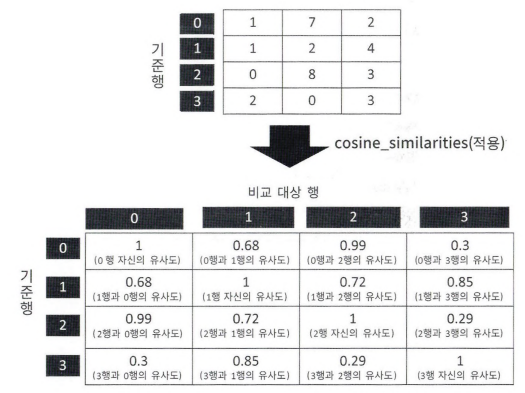

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim=cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


`cosine_similarity()` 호출로 생성된 genre_sim 객체는 movies_df의 genre_literal 칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 행(레코드)별 유사도 정보를 가지고 있으며, 결국은 movies_df DataFrame의 행렬 장르 유사도 값을 가지고 있는 것이다.

movies_df를 장르 기준으로 콘텐츠 기반 필터링을 수행하려면 movies_df의 개별 레코드에 대해서 가장 장르 유사도가 높은 순으로 다른 레코드를 추출해야 하는데, 이를 위해 앞에서 생성한 genre_sim 객체를 이용한다.

genre_sim 객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값을 추출하면 된다. 값이 높은 순으로 정렬된 비교 대상 행의 유사도 값이 아니라 비교 대상 행의 위치 인덱스임에 주의한다. 넘파이의 `argsort()[:, ::-1]`을 이용하면 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값을 간편하게 얻을 수 있다. `genre_sim.argsort()[:, ::-1]`를 사용해 높은 순으로 정렬된 비교 행 위치 인덱스 값을 가져오고 그중에 0번 레코드의 비교 행 위치 인덱스 값만 샘플로 추출해 보자.


In [10]:
genre_sim_sorted_ind=genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


반환된 값이 의미하는 것은 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그다음이 813번, 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻이다.

genre_sim_sorted_ind 객체는 각 레코드의 장르 코사인 유사도가 가장 높은 순으로 정렬된 타 레코드의 위치 인덱스 값을 가지고 있다. 이 위치 인덱스를 이용해 언제든지 특정 레코드와 코사인 유사도가 높은 다른 레코드를 추출할 수 있다.

## **장르 콘텐츠 필터링을 이용한 영화 추천**
장르 유사도에 따라 영화를 추천하는 함수를 생성한다. 함수명은 `find_sim_movie()`이며, 인자로 기반 데이터인 movies_df DataFrame, 레코드별 장르 코사인 유사도 인덱스를 가지고 있는 genre_sim_sorted_ind, 고객이 선정한 추천 기준이 되는 영화 제목, 추천할 영화 건수를 입력하면 추천 영화 정보를 가지는 DataFrame을 반환한다.

In [12]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie=df[df['title']==title_name]

  # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index=title_movie.index.values
  similar_indexes=sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임.
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes=similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

`find_sim_movie()` 함수를 이용해 영화 '대부'와 장르별로 유사한 영화 10개를 추천해 보겠다. `find_sim_movie(dataframe=movies, sorted_ind=genre_sim_sorted_ind, title='The Godfather', top_n=10)`을 호출한다.

In [13]:
similar_movies=find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


'대부 2편'이 가장 먼저 추천됐다. 그 외에 1847번 인덱스의 '좋은 친구들'도 대부와 비슷한 유형으로, 대부를 재미있게 봤다면 이 두 가지 모두 추천해야 할 영화일 것이다. 하지만 낯선 영화도 많다. '라이트 슬리퍼', 'Mi America', 'Kids' 등 대부를 좋아하는 고객에게 섣불리 추천하기에는 이해하기 어려운 영화도 있다. '라이트 슬리퍼'의 경우 평점이 낮은 편이고, 게다가 'Mi America'의 경우에는 평점이 0이다. 좀 더 개선이 필요하다.

이번에는 좀 더 많은 후보군을 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경한다. 영화의 평점 정보인 'vote_average' 값을 이용한다. vote_average는 0부터 10점 만점까지의 점수로 되어 있는데, 여러 관객이 평가한 평점을 평균한 것이다. 그런데 1명, 2명의 소수의 관객이 특정 영화에 만점이나 매우 높은 평점을 부여해 왜곡된 데이터를 가지고 있다. 이를 확인하기 위해 `sort_values()`를 이용해 평점('vote_average') 오름차순으로 movies_df를 정렬해서 10개만 출력해 보자.

In [16]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average',
                                                              ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


'쇼생크 탈출'이나 '대부' 같은 명작보다 높은 순위에 'Stiff Upper Lips', 'Me You and Five Bucks'와 같이 이름도 들어본 적 없는 영화가 더 높은 평점으로 있다. 이들은 모두 평가 횟수가 매우 작다. 이와 같은 왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요하다.

유명한 영화 평점 사이트인 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점 방식을 이용한다. 이 방식을 이용해 새롭게 평점을 부여한다. 가중 평점의 공식은 다음과 같다.

$$가중 평점=(v/(v+m))*R+(m/(v+m))*C$$

* v : 개별 영화에 평점을 투표한 횟수
* m : 평점을 부여하기 위한 최소 투표 횟수
* R : 개별 영화에 대한 평균 평점
* C : 전체 영화에 대한 평균 평점

V는 movies_df의 'vote_count' 값이며, R 값은 'vote_average' 값에 해당한다. C의 경우 전체 영화의 평균 평점이므로 movie_df['vote_average'].mean()으로 구할 수 있다. m의 경우는 투표 횟수에 따른 가중치를 직접 조절하는 역할을 하는데, m 값을 높이면 평점 투표 횟수가 많은 영화에 더 많은 가중 평점을 부여한다. m 값은 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정한다. 상위 60% 값은 Series 객체의 `quantile()`을 이용해 추출한다.

In [17]:
C=movies_df['vote_average'].mean()
m=movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


기존 평점을 새로운 가중 평점으로 변경하는 함수를 생성하고 이를 이용해 새로운 평점 정보인 'vote_weighted' 값을 만든다. 함수명은 `weighted_vote_average()`이다. 이 함수는 DataFrame의 레코드를 인자로 받아 이 레코드의 vote_count와 vote_averate 칼럼, 그리고 미리 추출된 m과 C 값을 적용해 레코드별 가중 평점을 반환한다. 해당 함수를 movies_df의 `apply()` 함수의 인자로 입력해 가중 평점을 계산한다.

In [18]:
percentile=0.6
m=movies_df['vote_count'].quantile(percentile)
C=movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v=record['vote_count']
  R=record['vote_average']

  return ((v/(v+m))*R)+((m/(m+v))*C)

movies_df['weighted_vote']=movies.apply(weighted_vote_average, axis=1)

새롭게 부여된 weighted_vote 평점이 높은 순으로 상위 10개의 영화를 추출한다.

In [19]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values(
    'weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


TOP 10에 대한 개인별 성향이 조금씩 달라서 위 결과에 이의가 있을지는 몰라도 위 영화 모두 매우 뛰어난 영화라는 점에는 이견이 없을 것이다. 이제 새롭게 정의된 평점 기준에 따라 영화를 추천해 보겠다. 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤에 weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출하는 방식으로 `find_sim_movie()` 함수를 변경한다. 변경된 `find_sim_movie()`를 이용해 다시 한 번 '대부'와 유사한 영화를 콘텐츠 기반 필터링 방식으로 추천해 보겠다.

In [20]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie=df[df['title']==title_name]
  title_index=title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes=sorted_ind[title_index, :(top_n*2)]
  similar_indexes=similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes=similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies=find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


이전에 추천된 영화보다 훨씬 나은 영화가 추천됐다. 특히 '원스 어폰 어 타임 인 아메리카'가 추천됐는데, 대부를 좋아하는 사람이라면 공감할 만한 추천 영화이다. 하지만 장르만으로 영화가 전달하는 많은 요소와 분위기, 그리고 개인이 좋아하는 성향을 반영하기에는 부족할 수 있다. 아마 좋아하는 영화배우나 감독을 보고 영화를 선택하는 경우가 더 많을 것이다. 앞의 장르를 기반으로 한 콘텐츠 필터링 예제를 좀 더 다양한 콘텐츠 기반으로 확장할 수 있다.